In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import numpy as np
import pandas as pd
import string
import re
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))


from importlib import reload
import time
import datetime
import json
import csv

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)

The calculations behind the work for  section 1 of this challenge is presented in this notebook.
In this calculation the momentum value is calculated in such a way that: 
* momentum on date t will be assign value 1 if price return for day t exhibits a positive autocorrelation, otherwise -1 is assigned

## Utility Functions

First of all, define a function *interpolate_fillna* to handle NA value in the dataset

In [2]:
# This is a function use to fill NA value in a pandas series, using the backfill method to fill any NA value with the next value in the series 
def interpolate_fillna(data):
    for c in data.columns.tolist():
        # only fill value if the column is not 'Date'
        if c!='Date':
            data[c] = data[c].interpolate().fillna(method='backfill')
    return data
 

## Data Loading

Now we load the dataset, and perform the following operation:
* use the interpolate_fillna function to remove NA value in the dataset
* convert the 'Date' column in pandas datetime data type 
* create the list *stock_cols* to keep a record on which columns are for stock data

In [3]:
# Load data
data = pd.read_csv('../input/returns_20181228.csv')
data['Date']=pd.to_datetime(data['Date'])
data = interpolate_fillna(data)
stock_cols = [c for c in data.columns.tolist() if c!='Date']

let's have a look at the data itself

In [4]:
data.head(5)

,Date,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,stock_9,stock_10,stock_11,stock_12,stock_13,stock_14,stock_15,stock_16,stock_17,stock_18,stock_19,stock_20,stock_21,stock_22,stock_23,stock_24,stock_25,stock_26,stock_27,stock_28,stock_29,stock_30,stock_31,stock_32,stock_33,stock_34,stock_35,stock_36,stock_37,stock_38,stock_39,stock_40,stock_41,stock_42,stock_43,stock_44,stock_45,stock_46,stock_47,stock_48,stock_49,stock_50,stock_51,stock_52,stock_53,stock_54,stock_55,stock_56,stock_57,stock_58,stock_59,stock_60,stock_61,stock_62,stock_63,stock_64,stock_65,stock_66,stock_67,stock_68,stock_69,stock_70,stock_71,stock_72,stock_73,stock_74,stock_75,stock_76,stock_77,stock_78,stock_79,stock_80,stock_81,stock_82,stock_83,stock_84,stock_85,stock_86,stock_87,stock_88,stock_89,stock_90,stock_91,stock_92,stock_93,stock_94,stock_95,stock_96,stock_97,stock_98,stock_99,stock_100,stock_101,stock_102,stock_103,stock_104,stock_105,stock_106,stock_107,stock_108,stock_109,stock_110,stock_111,stock_112,stock_113,stock_114,stock_115,stock_116,stock_117,stock_118,stock_119,stock_120,stock_121,stock_122,stock_123,stock_124,stock_125,stock_126,stock_127,stock_128,stock_129,stock_130,stock_131,stock_132,stock_133,stock_134,stock_135,stock_136,stock_137,stock_138,stock_139,stock_140,stock_141,stock_142,stock_143,stock_144,stock_145,stock_146,stock_147,stock_148,stock_149,stock_150,stock_151,stock_152,stock_153,stock_154,stock_155,stock_156,stock_157,stock_158,stock_159,stock_160,stock_161,stock_162,stock_163,stock_164,stock_165,stock_166,stock_167,stock_168,stock_169,stock_170,stock_171,stock_172,stock_173,stock_174,stock_175,stock_176,stock_177,stock_178,stock_179,stock_180,stock_181,stock_182,stock_183,stock_184,stock_185,stock_186,stock_187,stock_188,stock_189,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198,stock_199,stock_200,stock_201,stock_202,stock_203,stock_204,stock_205,stock_206,stock_207,stock_208,stock_209,stock_210,stock_211,stock_212,stock_213,stock_214,stock_215,stock_216,stock_217,stock_218,stock_219,stock_220,stock_221,stock_222,stock_223,stock_224,stock_225,stock_226,stock_227,stock_228,stock_229,stock_230,stock_231,stock_232,stock_233,stock_234,stock_235,stock_236,stock_237,stock_238,stock_239,stock_240,stock_241,stock_242,stock_243,stock_244,stock_245,stock_246,stock_247,stock_248,...,stock_890,stock_891,stock_892,stock_893,stock_894,stock_895,stock_896,stock_897,stock_898,stock_899,stock_900,stock_901,stock_902,stock_903,stock_904,stock_905,stock_906,stock_907,stock_908,stock_909,stock_910,stock_911,stock_912,stock_913,stock_914,stock_915,stock_916,stock_917,stock_918,stock_919,stock_920,stock_921,stock_922,stock_923,stock_924,stock_925,stock_926,stock_927,stock_928,stock_929,stock_930,stock_931,stock_932,stock_933,stock_934,stock_935,stock_936,stock_937,stock_938,stock_939,stock_940,stock_941,stock_942,stock_943,stock_944,stock_945,stock_946,stock_947,stock_948,stock_949,stock_950,stock_951,stock_952,stock_953,stock_954,stock_955,stock_956,stock_957,stock_958,stock_959,stock_960,stock_961,stock_962,stock_963,stock_964,stock_965,stock_966,stock_967,stock_968,stock_969,stock_970,stock_971,stock_972,stock_973,stock_974,stock_975,stock_976,stock_977,stock_978,stock_979,stock_980,stock_981,stock_982,stock_983,stock_984,stock_985,stock_986,stock_987,stock_988,stock_989,stock_990,stock_991,stock_992,stock_993,stock_994,stock_995,stock_996,stock_997,stock_998,stock_999,stock_1001,stock_1002,stock_1003,stock_1004,stock_1005,stock_1006,stock_1007,stock_1008,stock_1009,stock_1010,stock_1011,stock_1012,stock_1013,stock_1014,stock_1015,stock_1016,stock_1017,stock_1018,stock_1019,stock_1020,stock_1021,stock_1022,stock_1023,stock_1024,stock_1025,stock_1026,stock_1027,stock_1028,stock_1029,stock_1030,stock_1031,stock_1032,stock_1033,stock_1034,stock_1035,stock_1036,stock_1037,stock_1038,stock_1039,stock_1040,stock_1041,stock_1042,stock_1043,stock_1044,stock_1045,stock_1046,stoc

# Daily Momentum Calculation

The following code perform calculation for the daily momentum for each of the stock with the following dataframes:
* The dataframe *data_shift_tm1* is created to represent original data shift back one days, this represents information for t-1
* The dataframe *data_shift_tm2* is created to represent original data shift back two days this represents information for t-2
* The dataframe *data_daily_momentum* is created to capture momentum information on a daily basis for the stocks

In [5]:
data_shift_tm1= data[stock_cols].shift()
data_shift_tm2 = data_shift_tm1[stock_cols].shift()
data_daily_momentum = pd.DataFrame(columns=data.columns)
data_daily_momentum['Date'] = data['Date']

We then iterate through each column, and work out the daily moment for each given stock.
For each day of a stock, assign a daily moment value in the following way:
* 1: for day t if price reutrn is higher than that of t-1, and price return in date t-1 is higher than that of t-2. Or alternatively, for day t if price return is lower than that of day t-1, and price return in date t-1 is lower than that of t-2
* 0: if the above condition doesn't stand. 

After this, we calculate the mean momentum value for each day, and set the Date column to be the index of the *data_daily_momentum* 

In [6]:
# calculate the daily momentum for each stock in the dataset
for c in stock_cols:
    cond1 = (data[c]>data_shift_tm1[c]) & (data_shift_tm1[c]>data_shift_tm2[c])
    cond2 = (data[c]<data_shift_tm1[c]) & (data_shift_tm1[c]<data_shift_tm2[c])
    data_daily_momentum[c] = np.where((cond1 | cond2), 1, -1)

# calculate mean daily momentum for each day in the dataset
data_daily_momentum['mean_momentum'] = data_daily_momentum[stock_cols].mean(axis=1)
data_daily_momentum.set_index('Date', inplace=True)

# Mean Daily Momentum Visualization

We can now plot the mean daily momentum values agains the dates to see if we can spot a step change in the mean daily moment value.

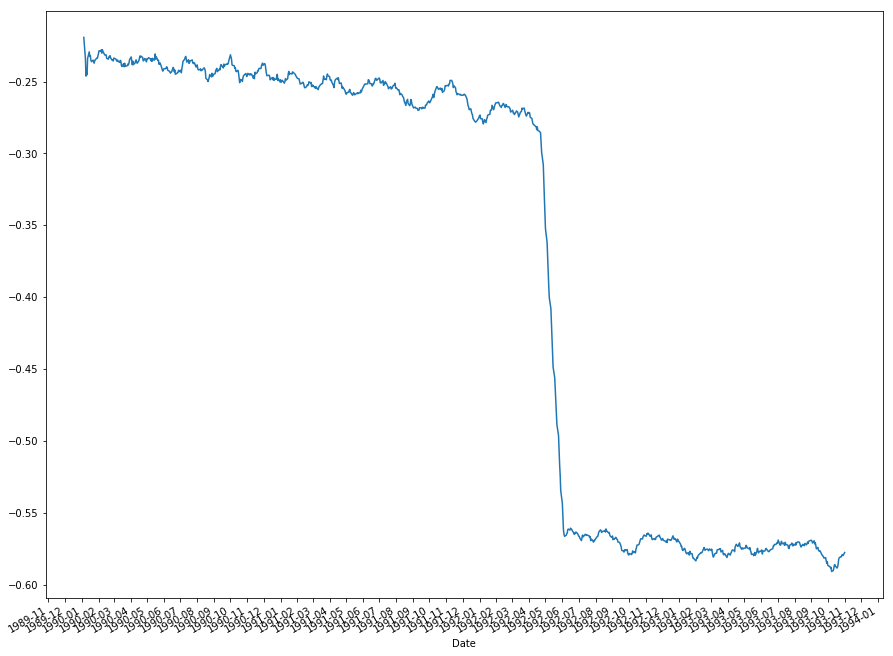

In [7]:
ax = data_daily_momentum['mean_momentum'][2:].rolling(window=30, min_periods=1).mean().plot(figsize=(15,12), x_compat=True)
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.show()

## Analysis and Calculation for Question 1 

**Question 1: In what month did the returns shift from exhibiting mean reversion to exhibiting momentum, or from exhibiting momentum to exhibiting mean reversion?**

From the above we can clearly see there is a step change starting from the month of April in 1992 (04-1992)

let's calculate the mean mothnly momentum value for each month, and visualize it again:

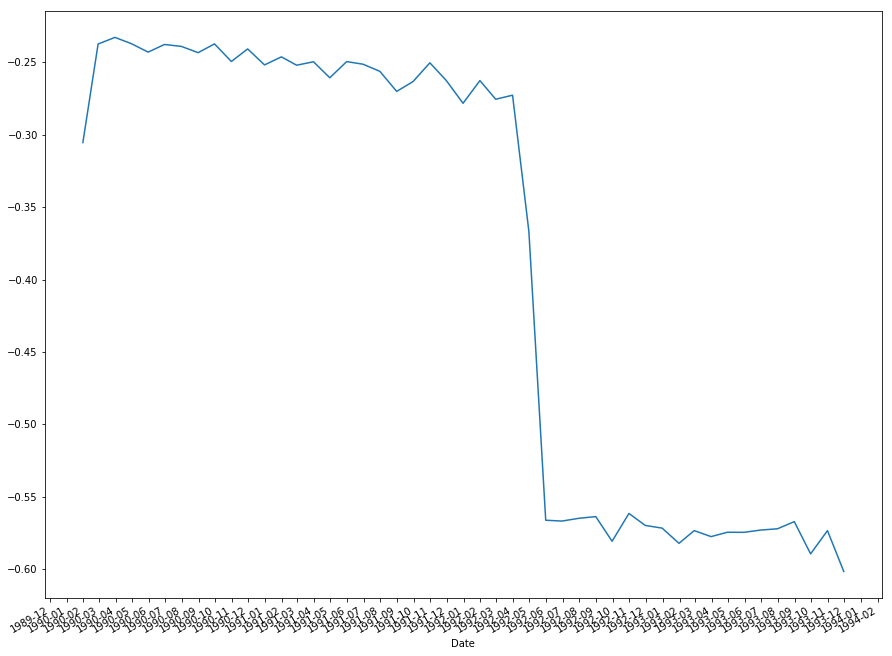

In [8]:
momentum_month_mean = data_daily_momentum['mean_momentum'].resample('M', how='mean')
ax = momentum_month_mean.plot(kind='line',figsize=(15,12), x_compat=True)
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.show()

again, the step change takes place on 04-1992.

Let have a look at the numerical values:

In [9]:
momentum_month_mean

Date
1990-01-31   -0.305347
1990-02-28   -0.237281
1990-03-31   -0.232695
1990-04-30   -0.237009
1990-05-31   -0.242868
1990-06-30   -0.237594
1990-07-31   -0.238915
1990-08-31   -0.243249
1990-09-30   -0.237193
1990-10-31   -0.249352
1990-11-30   -0.240670
1990-12-31   -0.251713
1991-01-31   -0.246148
1991-02-28   -0.251930
1991-03-31   -0.249541
1991-04-30   -0.260606
1991-05-31   -0.249428
1991-06-30   -0.251228
1991-07-31   -0.256140
1991-08-31   -0.270016
1991-09-30   -0.263241
1991-10-31   -0.250267
1991-11-30   -0.262406
1991-12-31   -0.278230
1992-01-31   -0.262548
1992-02-29   -0.275439
1992-03-31   -0.272648
1992-04-30   -0.366667
1992-05-31   -0.566332
1992-06-30   -0.566906
1992-07-31   -0.564989
1992-08-31   -0.563826
1992-09-30   -0.580861
1992-10-31   -0.561643
1992-11-30   -0.569925
1992-12-31   -0.571777
1993-01-31   -0.582289
1993-02-28   -0.573509
1993-03-31   -0.577651
1993-04-30   -0.574641
1993-05-31   -0.574687
1993-06-30   -0.573126
1993-07-31   -0.572249
1993-0

from the above values, we can see that mean monthly momentum drops from about about -0.27 in 03-1992 to about -0.56 in 05-1992, and stay at that level for the rest of the recorded data.

The month 04-1992, with a mean monthly momentum of -0.36 is in the middle range between these two steps 

For this reason, 04-1992 is the answer for question 1

## Analysis and Calculation for  Questions 2 and 3

**Question 2: During the time period when these stock returns had the momentum property, what was the average momentum?**
**Question 3: During the time period when these stock returns exhibited mean reversion, what was the average mean reversion?**

Since the month 04-1992 is the month where a step change in the moment value of the stocks, to answer question 2, we calculate the average momentum value from beginning of the data to 04-1992.
To answer question 3, we calculate the average momentum value from 04-1992 as mean reversion value

In [11]:
# momentum_month_mean.loc[momentum_month_mean.index<pd.to_datetime('1992-05-31')]
momentum_value = momentum_month_mean.loc[momentum_month_mean.index<=pd.to_datetime('1992-04-30')].mean()
reversion_value = momentum_month_mean.loc[momentum_month_mean.index>=pd.to_datetime('1992-04-30')].mean()
print('%0.6f' % momentum_value)
print('%0.6f' % reversion_value)

-0.257870
-0.563660


The answer for question 2 is the value of *momentum_value* : -0.257870

The answer for question 3 is the value of *reversion_value* : --0.563660